### Strand Classifier Using one Minhash Function
* A single threaded implementation of Strand as a SciKit Estimator using **only one** hashing function. 

**Training Data File:**
* File Name: RDP_All_Clean.strand
* Total classes: 64
* Longest sequence in file: 1,834  
* File Sequence Count: 4,786
* Input file size of 14,365 KB

**Hyperparameter Tuning:**
* GridSearchCV using Stratified 10-fold CV and 350 fits per model.
* Kmer lengths: 10, 15, 20, 40, 60, 70, 80.
* Minhash lengths: 100, 250, 500, 1000, 1500.
* All 35 average accuracy scores are plotted at each kmer / minhash length intersection.  
* Time: 9min 16s 
* Best Parms: kmer_length=20, minhash_length=1000
* Accuracy: 99.62%

**Inspection of Stratified 10-fold cv Predictions**:
* Correct Predictions:   4739
 * Out of a 1000 value minhash signature, on average, 789.54 are found in the training dataset (79.85%)  
* Incorrect Predictions: 47
 * Out of a 1000 value minhash signature, on average, 558.45 are found in the training dataset (55.84%)

**Inspection of training data:**
* There are 64 classes in the training dataset. 
* There are 127,506 minhash values in the training dataset.
* There are 174,650 categories associated to minhashes in the training dataset.
* Each minhash has, on average, 1.39 associated categories.  
* 111,476 minhashes have only 1 category associated, 8,625 have 2 categories associated, 4,405 have 3 or more.
* Categories range from having 1,149 minhashes to 11,122 minhashes associated.   

**Test - Penalize minhashes with multiple category associations:**
* Each minhash category association is worth 1 point 
* When the minhash is associated with more than 1 category, 
* During predictions, divide that 1 point equally across each associated category
* 10-fold stratified cv @ 90 / 10 splits and (kmer_length=15, minhash_length=500) = 9min 9s, 99.60% Accuracy

**Test - Penalize unbalanced categories:**
* Each minhash category association is no longer worth 1 point
* Each minhash category association is worth 1 - (Cat Count / Sum(All Category Counts))
* Unbalanced categories are penalized the larger they become based on the percentage of all
* 10-fold stratified cv @ 90 / 10 splits and (kmer_length=20, minhash_length=500) = 9min 34s, 99.64% Accuracy

**Test - Penalize unbalanced categories and multiple category associations:**

* Unbalanced Categories
 * Each minhash category association is no longer worth 1 point
 * Each minhash category association is worth 1 - (Cat Count / Sum(All Category Counts))
 * Unbalanced categories are penalized the larger they become based on the percentage of all 

* Multiple Category Associations
 * When the minhash is associated with more than 1 category, 
 * During predictions, divide the category's point value equally across each associated category

* 10-fold stratified cv @ 90 / 10 splits and (kmer_length=10, minhash_length=1000) = 9min 51s, 99.60% Accuracy


In [185]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += 1
        return class_scores

## Load the RDP Dataset

In [186]:
def read_fasta_file(file_path):
    X = []
    y = []
    with open(file_path, 'r') as dat:
        for line in dat.readlines():
            #print(line)
            if line[0] == '>':
                g_start = line.find("g__")
                g_end = line.find(";", g_start)
                genus = line[g_start:g_end]
                y.append(genus)
            else:
                X.append(line)
    return X, y

In [187]:
import pandas as pd

# Read in the fasta file
X, y = read_fasta_file('D:/StrandPy/Data/RDP_All_Clean.strand')
#Remove low count genera that halt cross validation
data = {'X': X,'y':y}
df = pd.DataFrame(data)

In [188]:
#Inspect counts for each class
vcts = df.y.value_counts()
low_vcts = vcts[vcts < 20].index.values

#Remove low count genera. Any classes < the fold count will halt cross validation
df = df[~df.y.isin(low_vcts)]

# Create X and y
X = df.X.values
y = df.y.values

print('File Size: ' + str(len(X)))

File Size: 4786


In [189]:
print('Longest Sequence Chars:' + str(len(max(X, key=len))))

Longest Sequence Chars:1834


## Inspect the categories we are trying to classify

In [190]:
pd.set_option('display.max_rows', 100)
df.y.value_counts()

g__Streptomycineae                     544
g__Micrococcineae                      488
g__Corynebacterineae                   401
g__Pseudonocardineae                   192
g__Streptosporangineae                 188
g__Bacillus                            177
g__Lactobacillus                       159
g__Pseudomonas                         136
g__Clostridium_sensu_stricto           130
g__Micromonosporineae                  129
g__Paenibacillus                       126
g__Propionibacterineae                 125
g__Mycoplasma                          114
g__Shewanella                           84
g__Vibrio                               77
g__Streptococcus                        76
g__Halomonas                            64
g__Flavobacterium                       63
g__Staphylococcus                       62
g__Burkholderia                         58
g__Sphingomonas                         57
g__Desulfovibrio                        55
g__Actinomycineae                       54
g__Chryseob

## Hypertune kmer_length and minhash_length parameters

In [110]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.2min finished


Wall time: 9min 16s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [111]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=20, minhash_length=1000, random_state=42)

In [112]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9962390305056414

In [113]:
# This magic just sets up matplotlib's interactive mode
%matplotlib inline
# So you have to explicitely import the module into the namespace
import matplotlib.pyplot as plt

In [114]:
# ************* WARNING - You must inspect the cv_results_ to determine which parameter is not repeately duplicated 
#                         row after row in cv_results_['params'].  This should be grid_param_1.
#                         In short, if the plot's data is not right, reverse grid_param_1 and grid_param_2.  
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    plt.rcParams["figure.figsize"] = (14,10)
    
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=10)
    ax.grid(True)

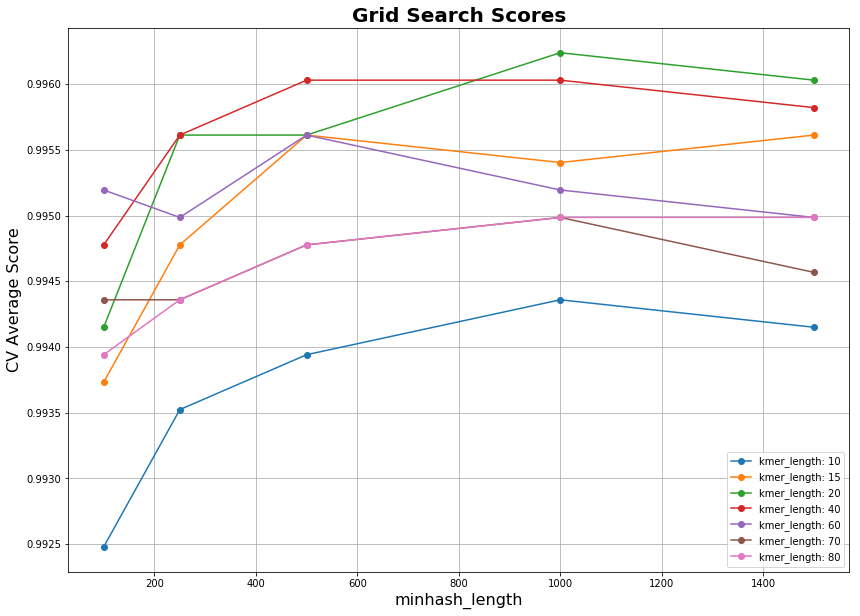

In [115]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

## How many minhash values get a hit in our training dictionary? 

In [191]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

yhats = np.zeros(len(y), dtype=np.object)
winning_scores = np.zeros(len(y))
scores_sums = np.zeros(len(y))

#Perform 10 fold cv, saving all predictions 
for test, train in cv.split(X,y):
    # Train and test on the one fold
    strand = StrandClassifierV2(kmer_length=20, minhash_length=1000, random_state=42)
    strand.fit(X[train],y[train])
    yhats[test] = strand.predict(X[test])
    winning_scores[test] = strand.winning_scores_
    scores_sums[test] = strand.scores_sums_

Wall time: 4min 8s


In [192]:
#Load results into a dataframe for analisys
data = {'y':y,'yhat':yhats,'winning_score':winning_scores,'scores_sum': scores_sums}
df = pd.DataFrame(data)

In [193]:
correct_yhats = df[df.y == df.yhat]
print(len(correct_yhats))
incorrect_yhats = df[df.y != df.yhat]
print(len(incorrect_yhats))

4746
40


### Hits on correct predictions

In [194]:
correct_yhats.mean(axis = 0)

winning_score     789.544248
scores_sum       8302.183312
dtype: float64

In [195]:
sum(correct_yhats.winning_score)     

3747177.0

In [200]:
# Calculate the minhash hit rate
798.54 / 1000

0.7985399999999999

### Hits on incorrect predictions
* Notice below that, on average, minhash signature values for incorrect predictions get a 55.5% hit rate 
  vs. 78.6% for correct predictions. 

In [197]:
incorrect_yhats.mean(axis = 0)

winning_score     558.45
scores_sum       7557.05
dtype: float64

In [201]:
# Calculate the minhash hit rate
558.45/1000

0.55845

### Inspect strand training data

In [202]:
strand.minhash_store_

{-9222840753819154398: {'g__Marinobacter',
  'g__Photobacterium',
  'g__Pseudoalteromonas',
  'g__Shewanella',
  'g__Vibrio'},
 -9214569812636807057: {'g__Marinobacter', 'g__Pseudomonas', 'g__Xanthomonas'},
 -9213065688710051732: {'g__Marinobacter', 'g__Pseudomonas'},
 -9167567614564580950: {'g__Marinobacter'},
 -9163438671984504365: {'g__Aeromonas',
  'g__Marinobacter',
  'g__Photobacterium',
  'g__Shewanella'},
 -9141420736159361176: {'g__Marinobacter',
  'g__Photobacterium',
  'g__Pseudoalteromonas',
  'g__Shewanella',
  'g__Vibrio'},
 -9129645927193904838: {'g__Marinobacter'},
 -9120833916157629043: {'g__Marinobacter'},
 -9120084483287414706: {'g__Acinetobacter',
  'g__Actinomycineae',
  'g__Aeromonas',
  'g__Alicyclobacillus',
  'g__Armatimonas/Armatimonadetes_gp1',
  'g__Bacillus',
  'g__Bartonella',
  'g__Bifidobacteriaceae',
  'g__Brevundimonas',
  'g__Burkholderia',
  'g__Campylobacter',
  'g__Chthonomonas/Armatimonadetes_gp3',
  'g__Clostridium_XI',
  'g__Clostridium_XlVa',
 

In [203]:
minhash_cats = [len(categories) for categories in strand.minhash_store_.values()]
category_count = sum(minhash_cats)
category_count

174650

In [204]:
minhash_count = len(strand.minhash_store_.keys())
minhash_count

127506

In [205]:
# Average categories per key 
category_count / minhash_count

1.3697394632409454

In [206]:
# Print count of minhash values for each caetgory count bin  
data = {'minhash_cats': minhash_cats}
mc = pd.DataFrame(data)
mc.minhash_cats.value_counts()\
    .rename_axis('Category Count')\
    .reset_index(name='Minhash Count')\
    .sort_values('Category Count')

,Category Count,Minhash Count
0,1,111476
1,2,8625
2,3,2910
3,4,1320
4,5,857
5,6,577
6,7,325
8,8,237
7,9,238
9,10,184


### Count the number of minhashes per category in our training data

In [207]:
# Count up the minhashes for each category 
cat_minhash_counts = dict()
for categories in strand.minhash_store_.values():
    for category in categories:
        cat_count = cat_minhash_counts.get(category, None)
        if cat_count == None:
            cat_minhash_counts[category] = 1
        else:
            cat_minhash_counts[category] += 1

# Print out the minhash count for each category              
df = pd.DataFrame(list(cat_minhash_counts.items()), columns=['Category', 'Minhash Count'])
df

,Category,Minhash Count
0,g__Photobacterium,1274
1,g__Marinobacter,1557
2,g__Vibrio,2161
3,g__Shewanella,2442
4,g__Pseudoalteromonas,1735
5,g__Xanthomonas,1149
6,g__Pseudomonas,3911
7,g__Aeromonas,1256
8,g__Rhizobium,1773
9,g__Virgibacillus,1332


## Test - Penalize minhashes with multiple category associations
* Each minhash category association is worth 1 point 
* When the minhash is associated with more than 1 category, 
* During predictions, divide that 1 point equally across each associated category 

In [129]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Calculate minhash score value based on how many 
                #  categories this minhash is associated with.
                score_value = 1 / len(minhash_categories)
                # Yes, add the score_value for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += score_value
        return class_scores

In [130]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.1min finished


Wall time: 9min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [131]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=15, minhash_length=500, random_state=42)

In [132]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9960300877559549

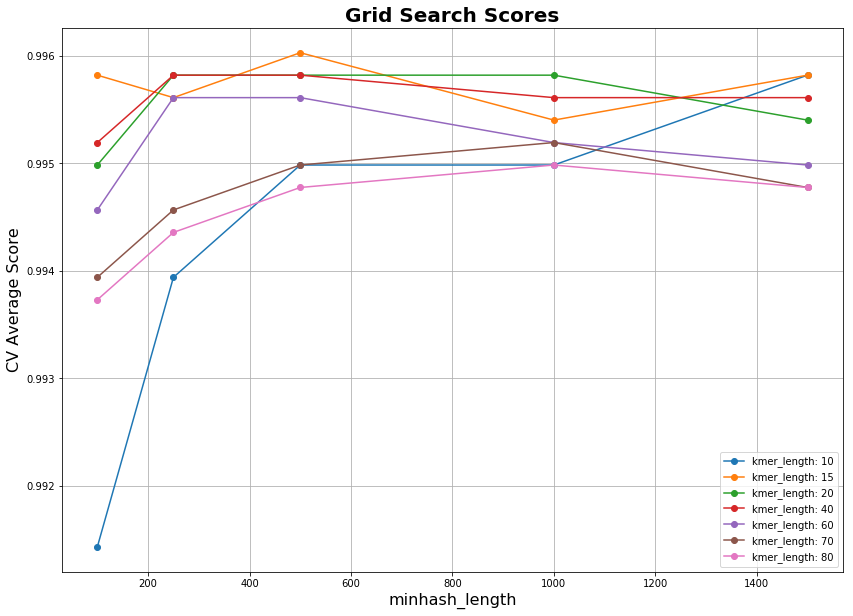

In [133]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

## Test - Penalize unbalanced categories
* Each minhash category association is no longer worth 1 point
* Each minhash category association is worth 1 - (Cat Count / Sum(All Category Counts))
* Unbalanced categories are penalized the larger they become based on the percentage of all 

In [134]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
        
        # Add up our category training totals and grand total
        cat_totals = dict()

        for categories in self.minhash_store_.values():
            for category in categories:
                cat_subtotal = cat_totals.get(category, None)
                if cat_subtotal == None:
                    cat_totals[category] = 1
                else:
                    cat_totals[category] += 1

        self.cat_totals_ = cat_totals
        self.cat_grand_total_ = sum(cat_totals.values())
        
        #weight each category using the formula for IDF 
        for category, cat_tot in self.cat_totals_.items():
            cat_tot = 1 - (cat_tot / self.cat_grand_total_)
            self.cat_totals_[category] = cat_tot

        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    #class_scores[category] += 1
                    # Lookup the IDF weighted scores
                    class_scores[category] += self.cat_totals_[category]
        return class_scores

In [135]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.5min finished


Wall time: 9min 34s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [136]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=20, minhash_length=500, random_state=42)

In [137]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9964479732553281

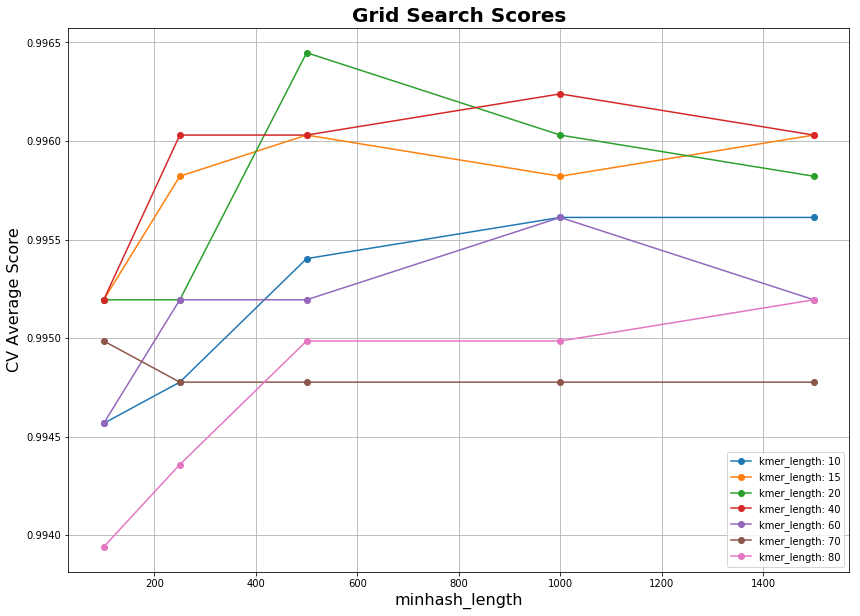

In [138]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

## Test - Penalize unbalanced categories and multiple category associations

### Unbalanced Categories
* Each minhash category association is no longer worth 1 point
* Each minhash category association is worth 1 - (Cat Count / Sum(All Category Counts))
* Unbalanced categories are penalized the larger they become based on the percentage of all 

### Multiple Category Associations
* When the minhash is associated with more than 1 category, 
* During predictions, divide the category's point value equally across each associated category

In [139]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
        
        # Add up our category training totals and grand total
        cat_totals = dict()

        for categories in self.minhash_store_.values():
            for category in categories:
                cat_subtotal = cat_totals.get(category, None)
                if cat_subtotal == None:
                    cat_totals[category] = 1
                else:
                    cat_totals[category] += 1

        self.cat_totals_ = cat_totals
        self.cat_grand_total_ = sum(cat_totals.values())
        
        #weight each category using the formula for IDF 
        for category, cat_tot in self.cat_totals_.items():
            cat_tot = 1 - (cat_tot / self.cat_grand_total_)
            self.cat_totals_[category] = cat_tot

        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    # Get the category's weighted score 
                    cate_weighted_score = self.cat_totals_[category]
                    
                    # Calculate minhash level score value based on how many 
                    #  categories a particular minhash is associated with.
                    score_value = cate_weighted_score / len(minhash_categories)
                    
                    # Lookup the IDF weighted scores
                    class_scores[category] += score_value
        return class_scores

In [140]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.7min finished


Wall time: 9min 51s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [141]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=10, minhash_length=1000, random_state=42)

In [142]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9960300877559549

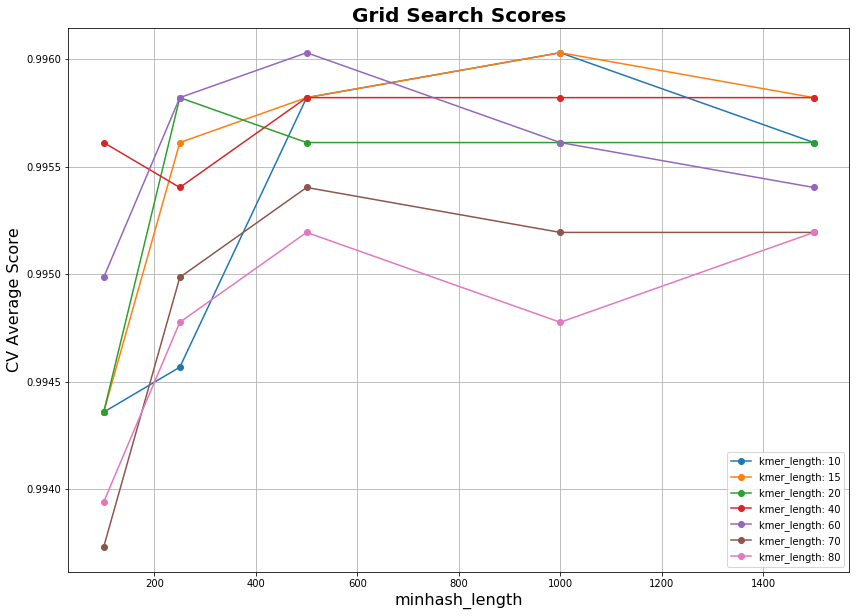

In [143]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')